### policy对创作者的影响，有无policy前后对比

#### 一. 充电专属政策有激励创作者进行更多创作吗

1. 对比policy前后创作者total video数量/month的变化，total video duration/month变化

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Load processed data
df = pd.read_parquet("../data/processed/processed_videos.parquet")

1.1 初次处理：直接plot monthly video numbers and total duration

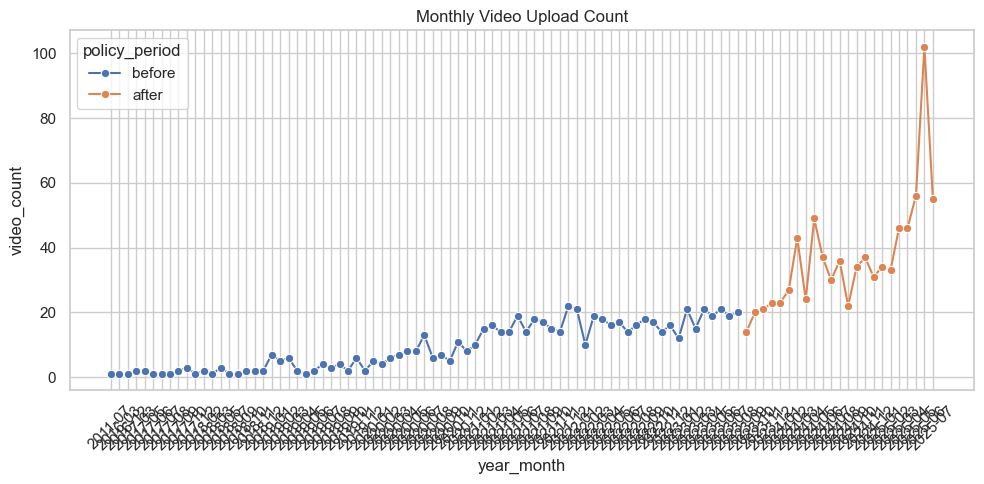

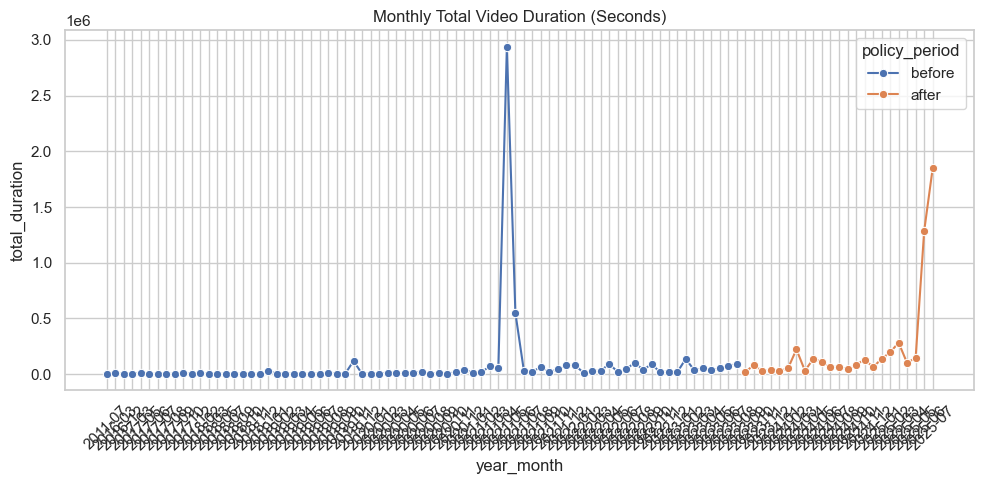

In [5]:
# 📊 Task 1: Policy Impact on Upload Volume & Duration

# Create "policy_period" label
df["policy_period"] = df["after_policy"].map({True: "after", False: "before"})

# Group by year_month and policy period
monthly_stats = df.groupby(["year_month", "policy_period"]).agg(
    video_count=("bv", "count"),
    total_duration=("duration", "sum")
).reset_index()

# 
# Plot: Monthly video count
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_stats, x="year_month", y="video_count", hue="policy_period", marker="o")
plt.title("Monthly Video Upload Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Monthly total duration
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_stats, x="year_month", y="total_duration", hue="policy_period", marker="o")
plt.title("Monthly Total Video Duration (Seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


在1.1的naive处理后我们发现没有考虑**创作者本身随着时间自然变化的趋势**，有可能误把这些自然增长当成政策效应
因此一下1.2将**加入创作者固定效应**，1.3将**时间固定效应**

1.2 加入创作者固定效应

    Step 1: 构建创作者×月份面板 (创作者每个月一行，并对“没发视频的月份”补 0 )
    每个创作者，每个月发了多少视频，总时长是多少
    eg:
<img src="image1-创作者*月度面板.png" alt="Table Example" width="600">

    最终，step 1这一步是将数据存成了一个长表，聚合了每个创作者一个月的视频数量和总时长，便于后续regression
<img src="image2-长表.png" alt="Table Example" width="600">

In [ ]:
import pandas as pd
import numpy as np

# === 配置列名 ===
CREATOR_COL = 'author_mid'       
MONTH_COL   = 'year_month'       # 已有 year_month
DURATION_COL= 'duration'         # 总时长的列名
VIDEO_ID_COL= 'bv'               # 视频唯一ID列，用来计数

# 1) 将时间信息string格式改为timestamp格式，每月第一天，确保可排序，eg: 2023-07 (Period[M]) → 2023-07-01 00:00:00 (Timestamp)
work = df.copy()
work[MONTH_COL] = pd.to_datetime(work[MONTH_COL]).dt.to_period('M').dt.to_timestamp()

# 2) 按 创作者×月份 聚合到月度
panel = (work
         .groupby([CREATOR_COL, MONTH_COL])
         .agg(video_count_month=(VIDEO_ID_COL, 'count'),
              duration_sum_month=(DURATION_COL, 'sum'))
         .reset_index())

# 3) 为每个创作者补齐全范围内的所有月份（没发视频的月也要有一行，填0）
min_m, max_m = panel[MONTH_COL].min(), panel[MONTH_COL].max()
all_months = pd.date_range(min_m, max_m, freq='MS')
creators = panel[CREATOR_COL].unique()
full_index = pd.MultiIndex.from_product([creators, all_months], names=[CREATOR_COL, MONTH_COL])

panel = (panel
         .set_index([CREATOR_COL, MONTH_COL])
         .reindex(full_index)
         .reset_index())

for c in ['video_count_month','duration_sum_month']:
    panel[c] = panel[c].fillna(0)

# 4) 构造政策后标记 post（按你平台的正式上线月设置）
policy_date = pd.Timestamp('2023-09-01')
panel['post'] = (panel[MONTH_COL] >= policy_date).astype(int)

# 5) 只保留“政策前后都至少有两个月观测”的创作者，避免单侧样本导致偏差
pre_n  = panel[panel[MONTH_COL] <  policy_date].groupby(CREATOR_COL)[MONTH_COL].nunique()
post_n = panel[panel[MONTH_COL] >= policy_date].groupby(CREATOR_COL)[MONTH_COL].nunique()
keep_creators = pre_n[pre_n>=2].index.intersection(post_n[post_n>=2].index)
panel = panel[panel[CREATOR_COL].isin(keep_creators)].copy()





    Step 2: 

In [ ]:
# run %pip install linearmodels  if not installed
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# 设定面板索引（creator × month）
panel_fe = panel.set_index([CREATOR_COL, MONTH_COL]).sort_index()

results = {}
for y_col in ['video_count_month', 'duration_sum_month']:
    exog = sm.add_constant(panel_fe[['post']])       # 自变量：post（+常数）
    mod  = PanelOLS(panel_fe[y_col], exog,
                    entity_effects=True)             # 仅创作者固定效应
    res  = mod.fit(cov_type='clustered',
                   cluster_entity=True)              # 按创作者聚类稳健SE
    results[y_col] = res
    print(f'\n=== Outcome: {y_col} ===')
    print(res.summary)


2. 每月充电视频比例变化

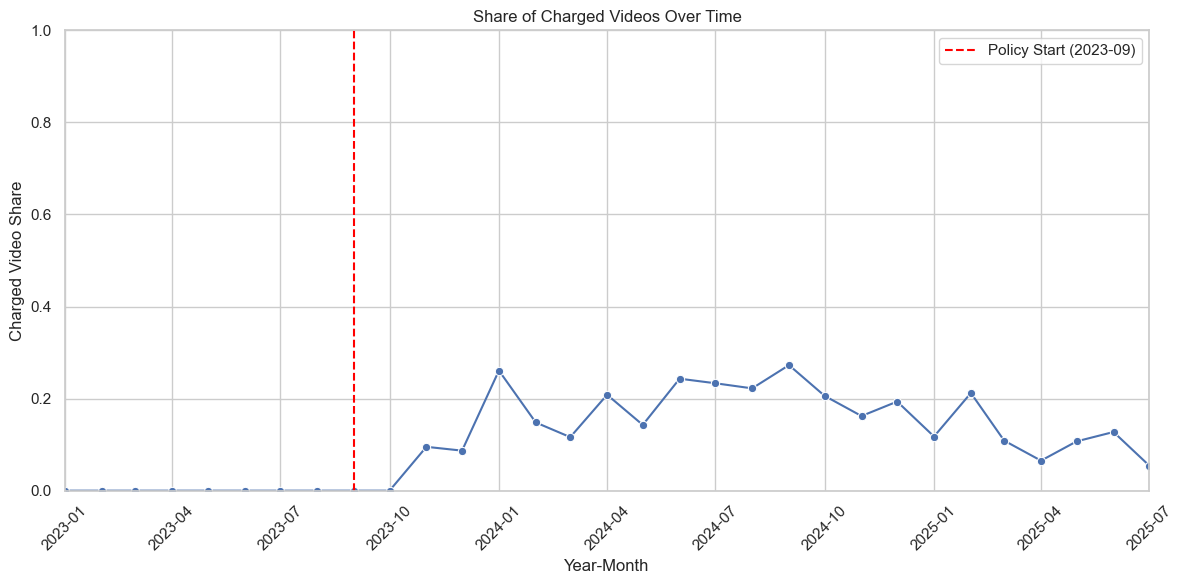

In [7]:
# Ensure datetime format
df['year_month'] = pd.to_datetime(df['year_month'], format="%Y-%m")
# Group by month and calculate share of charged videos
monthly_charged_stats = (
    df.groupby('year_month')['charged']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'charged_share', 'count': 'video_count'})
)
monthly_charged_stats.index = pd.to_datetime(monthly_charged_stats.index)
# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_charged_stats, x=monthly_charged_stats.index, y='charged_share', marker='o')
plt.axvline(pd.to_datetime("2023-09-01"), color="red", linestyle="--", label="Policy Start (2023-09)")
plt.title("Share of Charged Videos Over Time")
plt.ylabel("Charged Video Share")
plt.xlabel("Year-Month")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.xlim(pd.to_datetime("2023-01-01"), df['year_month'].max())  # <-- x-axis range
plt.legend()
plt.tight_layout()
plt.show()


#### 二. Up主在开通充电功能后长期的engagement（播放、评论、点赞）是否有衰退/提升

1. 对每月所有视频的view, like, comment, 取平均值进行趋势分析

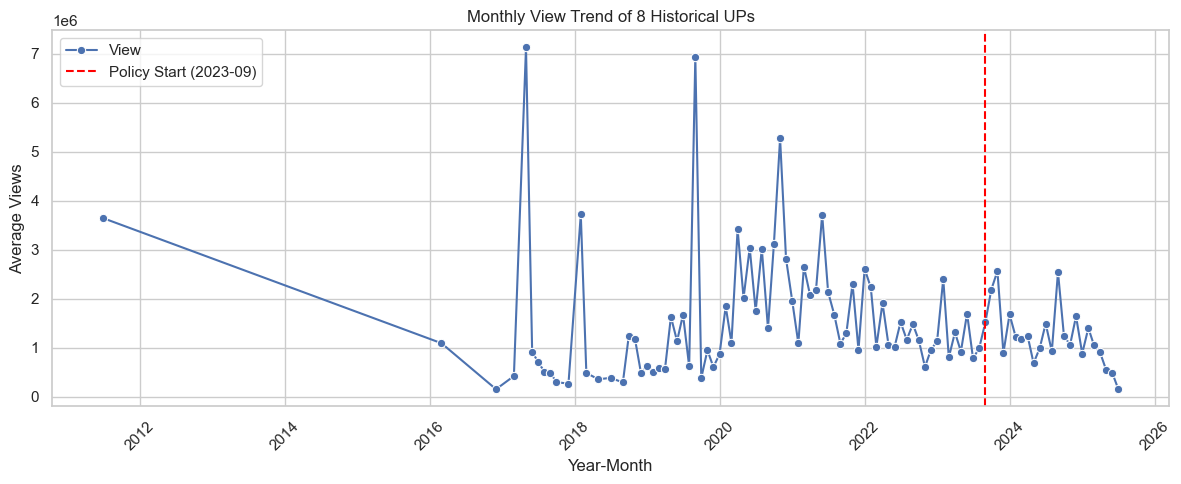

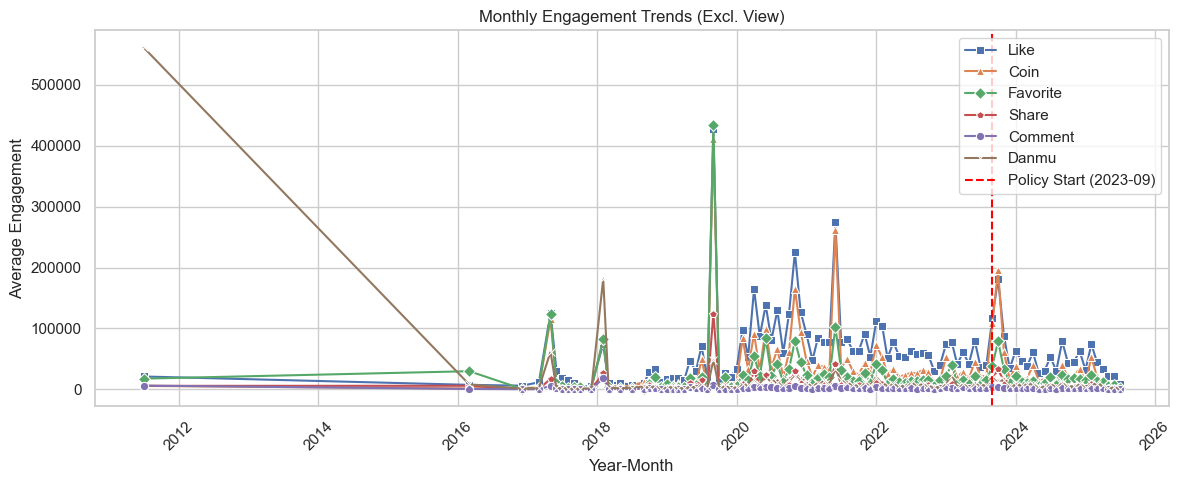

In [8]:
# 将8位历史类UP主filter出来
#target_authors = ["食贫道", "唠点历史", "历史调研室", "思维碰撞机", "李唐Yo", "森纳映画", "卢格杜努姆的奥古斯丁"]
#df = df[df['author'].isin(target_authors)].copy()

# 确保 year_month 是 datetime 格式
df['year_month'] = pd.to_datetime(df['year_month'], format="%Y-%m")

# 每月聚合 engagement 指标
monthly_stats = (
    df.groupby('year_month')[['view', 'like', 'coin', 'favorite', 'share', 'comment', 'danmaku']]
    .mean()
    .reset_index()
)

# 画view趋势图
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_stats, x='year_month', y='view', label='View', marker='o')
plt.axvline(pd.to_datetime("2023-09-01"), color="red", linestyle="--", label="Policy Start (2023-09)")
plt.title("Monthly View Trend of 8 Historical UPs")
plt.xlabel("Year-Month")
plt.ylabel("Average Views")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 画其他 engagement 指标趋势图
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_stats, x='year_month', y='like', label='Like', marker='s')
sns.lineplot(data=monthly_stats, x='year_month', y='coin', label='Coin', marker='^')
sns.lineplot(data=monthly_stats, x='year_month', y='favorite', label='Favorite', marker='D')
sns.lineplot(data=monthly_stats, x='year_month', y='share', label='Share', marker='p')
sns.lineplot(data=monthly_stats, x='year_month', y='comment', label='Comment', marker='o')
sns.lineplot(data=monthly_stats, x='year_month', y='danmaku', label='Danmu', marker='x')

plt.axvline(pd.to_datetime("2023-09-01"), color="red", linestyle="--", label="Policy Start (2023-09)")
plt.title("Monthly Engagement Trends (Excl. View)")
plt.xlabel("Year-Month")
plt.ylabel("Average Engagement")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




2. 为了去除极端值影响，进行一些操作

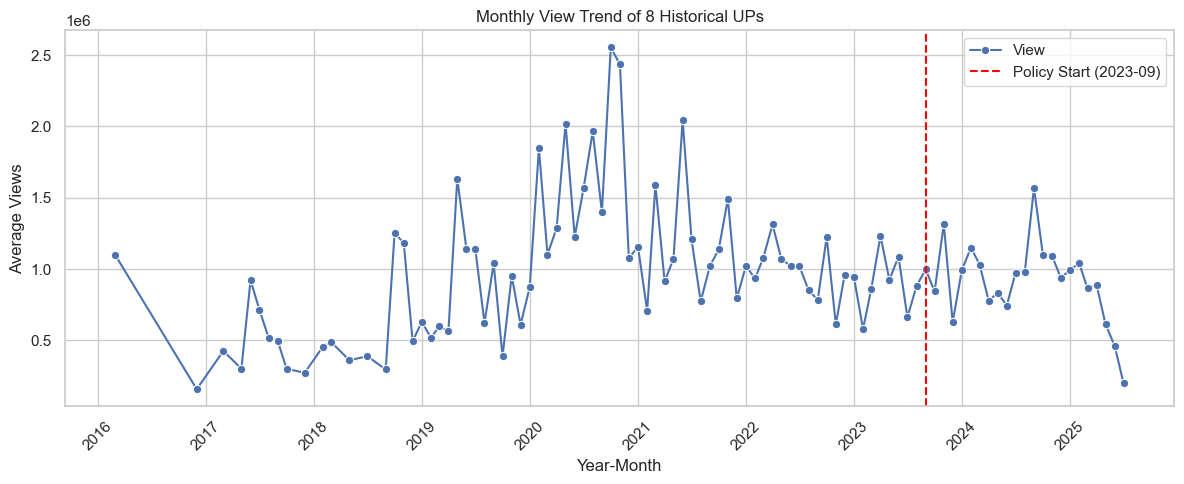

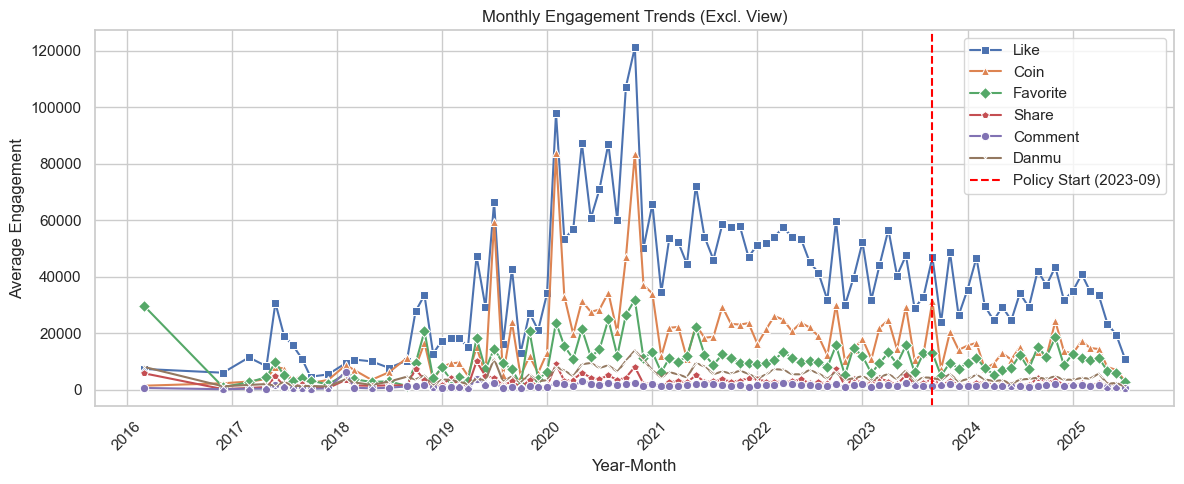

In [9]:
# 定义裁剪函数：去除每列上下1%极端值
def remove_outliers_by_percentile(df, columns, lower=0.01, upper=0.99):
    for col in columns:
        low = df[col].quantile(lower)
        high = df[col].quantile(upper)
        df = df[(df[col] >= low) & (df[col] <= high)]
    return df

# 1. 剔除极端值（上下1%）
filtered_df = remove_outliers_by_percentile(
    df,
    columns=['view', 'like', 'coin', 'favorite', 'share', 'comment', 'danmaku'],
    lower=0.01,
    upper=0.99
)

# 2. 用中位数/平均数聚合
monthly_stats = (
    filtered_df.groupby('year_month')[['view', 'like', 'coin', 'favorite', 'share', 'comment', 'danmaku']]
    .mean()
    .reset_index()
)

# 画view趋势图
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_stats, x='year_month', y='view', label='View', marker='o')
plt.axvline(pd.to_datetime("2023-09-01"), color="red", linestyle="--", label="Policy Start (2023-09)")
plt.title("Monthly View Trend of 8 Historical UPs")
plt.xlabel("Year-Month")
plt.ylabel("Average Views")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 画其他 engagement 指标趋势图
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_stats, x='year_month', y='like', label='Like', marker='s')
sns.lineplot(data=monthly_stats, x='year_month', y='coin', label='Coin', marker='^')
sns.lineplot(data=monthly_stats, x='year_month', y='favorite', label='Favorite', marker='D')
sns.lineplot(data=monthly_stats, x='year_month', y='share', label='Share', marker='p')
sns.lineplot(data=monthly_stats, x='year_month', y='comment', label='Comment', marker='o')
sns.lineplot(data=monthly_stats, x='year_month', y='danmaku', label='Danmu', marker='x')

plt.axvline(pd.to_datetime("2023-09-01"), color="red", linestyle="--", label="Policy Start (2023-09)")
plt.title("Monthly Engagement Trends (Excl. View)")
plt.xlabel("Year-Month")
plt.ylabel("Average Engagement")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()